**Run the following two cells before you begin.**

In [1]:
%autosave 10

Autosaving every 10 seconds


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

%matplotlib inline

**First, import the cleaned data set. Then, select the features from the DataFrame of the case study data.**
    
These features should be: `'LIMIT_BAL'`, `'EDUCATION'`, `'MARRIAGE'`, `'AGE'`, `'PAY_1'`, `'BILL_AMT1'`, `'BILL_AMT2'`, `'BILL_AMT3'`, `'BILL_AMT4'`, `'BILL_AMT5'`, `'BILL_AMT6'`, `'PAY_AMT1'`, `'PAY_AMT2'`, `'PAY_AMT3'`, `'PAY_AMT4'`, `'PAY_AMT5'`, AND `'PAY_AMT6'`.

In [5]:
# Import data set
df = pd.read_csv("cleaned_data.csv")
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,EDUCATION_CAT,graduate school,high school,others,university
0,798fc410-45c1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,1,university,0,0,0,1
1,8a8c8f3b-8eb4,120000,2,2,2,26,-1,2,0,0,...,1000,1000,0,2000,1,university,0,0,0,1
2,85698822-43f5,90000,2,2,2,34,0,0,0,0,...,1000,1000,1000,5000,0,university,0,0,0,1
3,0737c11b-be42,50000,2,2,1,37,0,0,0,0,...,1200,1100,1069,1000,0,university,0,0,0,1
4,3b7f77cc-dbc0,50000,1,2,1,57,-1,0,-1,0,...,10000,9000,689,679,0,university,0,0,0,1


In [6]:
# Create features list
features_response = ['LIMIT_BAL', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 
                     'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 
                     'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 
                     'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5','PAY_AMT6']

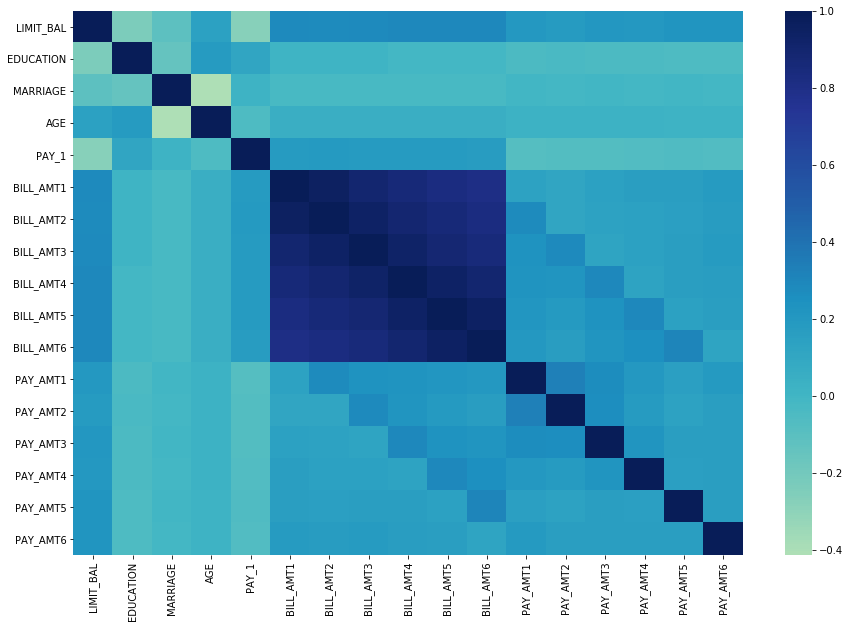

In [9]:
corr = df[features_response].corr()

plt.figure(figsize = (15,10))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            center=0,cmap="YlGnBu")
plt.show()

In [12]:
X = df[features_response]
y = df['default payment next month']
X.shape, y.shape

((26664, 17), (26664,))

_____________________________________________________
**Next, make a 80:20 train/test split using a random seed of 24.**

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state = 24)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((21331, 17), (21331,), (5333, 17), (5333,))

### Performing Stratified KFold cross Validation on Synthetic Data

In [14]:
C_val_exponents = np.linspace(3,-3,13)
print(C_val_exponents)

C_vals = np.float(10)**C_val_exponents
print(C_vals)

[ 3.   2.5  2.   1.5  1.   0.5  0.  -0.5 -1.  -1.5 -2.  -2.5 -3. ]
[1.00000000e+03 3.16227766e+02 1.00000000e+02 3.16227766e+01
 1.00000000e+01 3.16227766e+00 1.00000000e+00 3.16227766e-01
 1.00000000e-01 3.16227766e-02 1.00000000e-02 3.16227766e-03
 1.00000000e-03]


In [21]:
from sklearn.metrics import roc_curve

In [22]:
def cross_val_C_search(k_folds, C_vals, model, X, Y):
    
    n_folds = k_folds.n_splits
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))
    
    cv_test_roc = [[]]*len(C_vals)
    
    for c_val_counter in range(len(C_vals)):
        
        #Set the C value for the model object
        model.C = C_vals[c_val_counter]
        
        #Count folds for each value of C
        fold_counter = 0
        
        #Get training and testing indices for each fold
        for train_index, test_index in k_folds.split(X, Y):
            
            #Subset the features and response, for training and testing data for
            #this fold
            X_cv_train, X_cv_test = X[train_index], X[test_index]
            y_cv_train, y_cv_test = Y[train_index], Y[test_index]
            
            #Fit the model on the training data
            model.fit(X_cv_train, y_cv_train)
            
            #Get the training ROC AUC
            y_cv_train_predict_proba = model.predict_proba(X_cv_train)
            cv_train_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_train, y_cv_train_predict_proba[:,1])
            
            
            #Get the testing ROC AUC
            y_cv_test_predict_proba = model.predict_proba(X_cv_test)
            cv_test_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_test, y_cv_test_predict_proba[:,1])
            
            #Testing ROC curves for each fold
            this_fold_roc = roc_curve(y_cv_test, y_cv_test_predict_proba[:,1])
            cv_test_roc[c_val_counter].append(this_fold_roc)
            
            #Increment the fold counter
            fold_counter += 1
            
        #Indicate progress
        print('Done with C = {}'.format(lr_syn.C))

    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

X_synthetic, y_synthetic = make_classification(
    n_samples=1000, n_features=200,
    n_informative=3, n_redundant=10,
    n_repeated=0, n_classes=2,
    n_clusters_per_class=2, weights=None,
    flip_y=0.01, class_sep=0.8,
    hypercube=True, shift=0.0,
    scale=1.0, shuffle=True,
    random_state=24
)

X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(
    X_synthetic, y_synthetic,
    test_size=0.2, random_state=24
)

lr_syn = LogisticRegression(solver='liblinear', penalty='l1', C=1000, random_state=1)

n_folds = 4

k_folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1)

cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = \
cross_val_C_search(k_folds, C_vals, lr_syn, X_syn_train, y_syn_train)

Done with C = 1000.0
Done with C = 316.22776601683796
Done with C = 100.0
Done with C = 31.622776601683793
Done with C = 10.0
Done with C = 3.1622776601683795
Done with C = 1.0
Done with C = 0.31622776601683794
Done with C = 0.1
Done with C = 0.03162277660168379
Done with C = 0.01
Done with C = 0.0031622776601683794
Done with C = 0.001


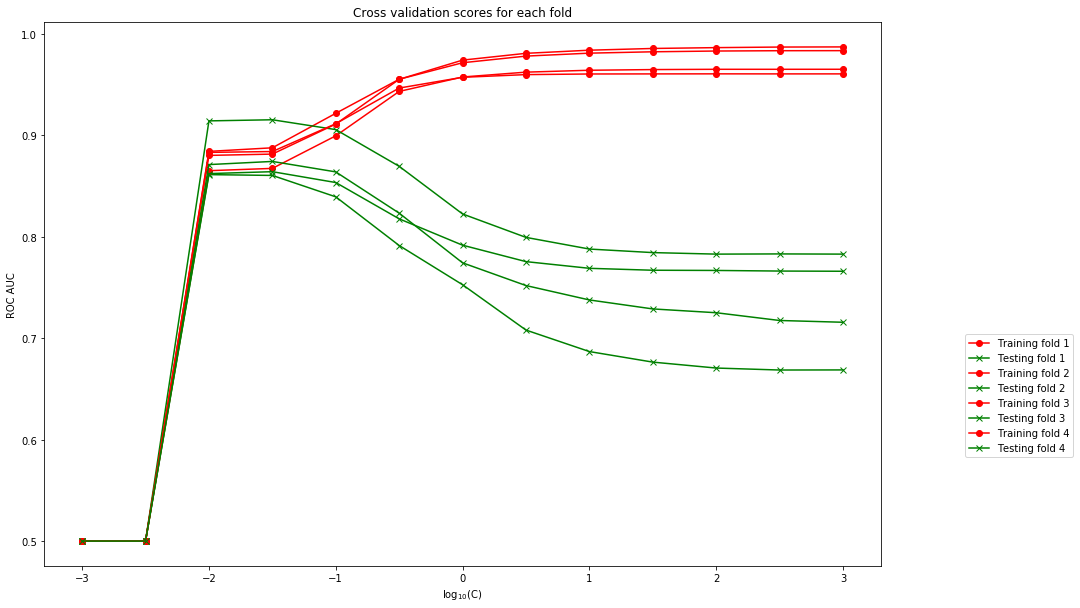

In [24]:
plt.figure(figsize = (15,10))

for this_fold in range(n_folds):
    plt.plot(C_val_exponents, cv_train_roc_auc[this_fold], '-o',
             color='red', label='Training fold {}'.format(this_fold+1))
    plt.plot(C_val_exponents, cv_test_roc_auc[this_fold], '-x',
             color='green', label='Testing fold {}'.format(this_fold+1))
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend(loc = [1.1, 0.2])
plt.title('Cross validation scores for each fold')
plt.show()

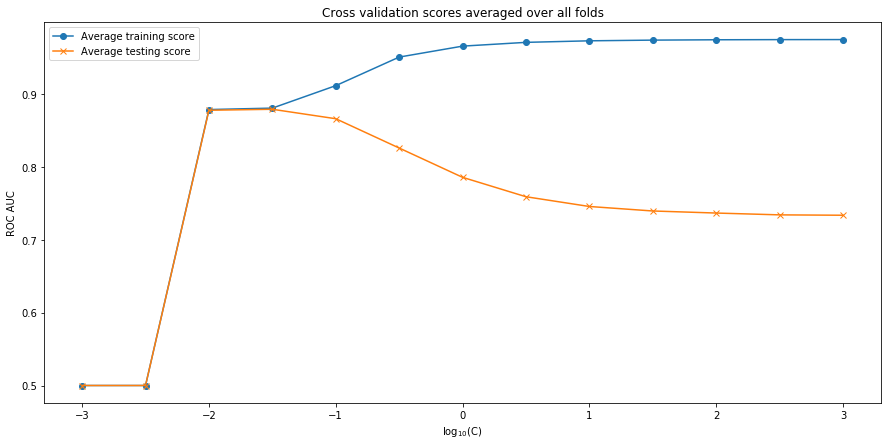

In [25]:
plt.figure(figsize = (15,7))
plt.plot(C_val_exponents, np.mean(cv_train_roc_auc, axis=0), '-o',
        label='Average training score')
plt.plot(C_val_exponents, np.mean(cv_test_roc_auc, axis=0), '-x',
        label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross validation scores averaged over all folds')
plt.show()

**OBSERVATION:** From this plot, it's clear that C = 10-1.5 and 10-2 are the best values of C. There is little or no overfitting here, as the average training and testing scores are nearly the same. You could search a finer grid of C values (that is C = 10-1.1, 10-1.2, and so on) in order to more precisely locate a C value. However, from our graph we can see that either C = 10-1.5 or C = 10-2 will likely be good solutions. We will move forward with C = 10-1.5.

In [26]:
# Code to locate the c value where exponent is -1.5
best_C_val_bool = C_val_exponents == -1.5
best_C_val_bool.astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [27]:
best_C_val_ix = np.argmax(best_C_val_bool)
best_C_val_ix

9

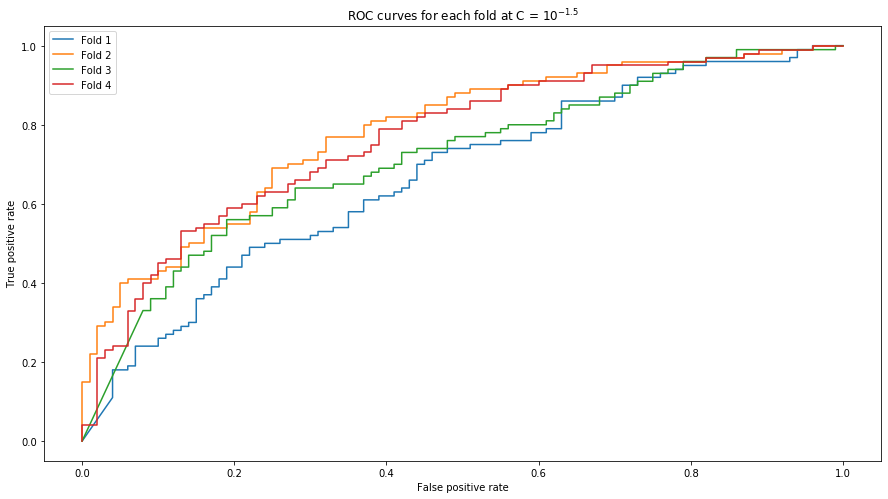

In [28]:
plt.figure(figsize = (15,8))
for this_fold in range(n_folds):
    fpr = cv_test_roc[best_C_val_ix][this_fold][0]
    tpr = cv_test_roc[best_C_val_ix][this_fold][1]
    plt.plot(fpr, tpr, label='Fold {}'.format(this_fold+1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves for each fold at C = $10^{-1.5}$')
plt.legend()
plt.show()

In [29]:
lr_syn.C = 10**(-1.5)
lr_syn.fit(X_syn_train, y_syn_train)

LogisticRegression(C=0.03162277660168379, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=1, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
y_syn_train_predict_proba = lr_syn.predict_proba(X_syn_train)
print(f"Test Set AUC ROC Score: {roc_auc_score(y_syn_train, y_syn_train_predict_proba[:,1])}")

Test Set AUC ROC Score: 0.8802812499999999


In [31]:
y_syn_test_predict_proba = lr_syn.predict_proba(X_syn_test)
print(f"Train Set AUC ROC Score: {roc_auc_score(y_syn_test, y_syn_test_predict_proba[:,1])}")

Train Set AUC ROC Score: 0.8847884788478848


We know that L1 regularization works by decreasing the magnitude (that is, absolute value) of coefficients of the logistic regression. It can also set some coefficients to zero, therefore performing feature selection. In the next step, we will determine how many coefficients were set to zero.

In [32]:
sum((lr_syn.coef_ != 0)[0])

2

In [33]:
lr_syn.intercept_

array([0.])

_____________________________________________________
**Then, instantiate the `MinMaxScaler` to scale the data.**

In [34]:
from sklearn.preprocessing import MinMaxScaler

min_max_sc = MinMaxScaler()

_____________________________________________________
**Next, instantiate a logistic regression model with the `saga` solver, L1 penalty, and set `max_iter` to 1,000 as we want the solver to have enough iterations to find a good solution.**

In [35]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(solver = 'saga', penalty = 'l1', max_iter = 1000)
lr_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

_____________________________________________________
**Next, import the `Pipeline` class and create a `Pipeline` with the scaler and the logistic regression model, using the names `'scaler'` and `'model'` for the steps, respectively.**

In [36]:
from sklearn.pipeline import Pipeline

scale_lr_pipeline = Pipeline(steps = [('scaler',min_max_sc), ('model', lr_model)])

_____________________________________________________
**Now, use the `get_params` method to view the parameters from each stage of the pipeline.**

In [37]:
# Use `get_params`
scale_lr_pipeline.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
  ('model',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, l1_ratio=None, max_iter=1000,
                      multi_class='auto', n_jobs=None, penalty='l1',
                      random_state=None, solver='saga', tol=0.0001, verbose=0,
                      warm_start=False))],
 'verbose': False,
 'scaler': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'model': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='auto', n_jobs=None, penalty='l1',
                    random_state=None, solver='saga', tol=0.0001, verbose=0,
                    warm_start=False),
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'model__C': 1.0,
 'model__class_weight': None,
 'model__dual': False,
 'model__fi

**Use the `set_params` method to change the the `model__C` parameter to 2.**

In [38]:
# View what `model__C` is set to currently
scale_lr_pipeline.get_params()['model__C']

1.0

In [39]:
# Change `model__C` to 2
scale_lr_pipeline.set_params(model__C = 2.0)
scale_lr_pipeline.get_params()['model__C']

2.0

_____________________________________________________
**Then, create a smaller range of C values to test with cross-validation, as these models will take longer to train and test with more data than our previous activities.**

**Use C_vals = [$10^2$, $10$, $1$, $10^{-1}$, $10^{-2}$, $10^{-3}$].**


<details>
    <summary>Hint:</summary>
    Recall that exponents in Python use the ** operator.
</details>

In [40]:
C_val_exponents = np.linspace(2,-3,6)
print(C_val_exponents)

C_vals = np.float(10)**C_val_exponents
print(C_vals)

[ 2.  1.  0. -1. -2. -3.]
[1.e+02 1.e+01 1.e+00 1.e-01 1.e-02 1.e-03]


Now, define `k_folds` using `StratifiedKFold`. The number of folds should be 4. Set the random state to 1.

In [41]:
k_folds = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 1)

_____________________________________________________
**Next, make a new version of the `cross_val_C_search` function, called `cross_val_C_search_pipe`. Instead of the model argument, this function will take a pipeline argument. The changes inside the function will be to set the `C` value using `set_params(model__C = <value you want to test>)` on the pipeline, replacing the model with the pipeline for the fit and `predict_proba` methods, and accessing the `C` value using `pipeline.get_params()['model__C']` for the printed status update.**

In [42]:
def cross_val_C_search_pipe(k_folds, C_vals, pipeline_model, X, Y):
    
    n_folds = k_folds.n_splits
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))
    
    cv_test_roc = [[]]*len(C_vals)
    
    for c_val_counter in range(len(C_vals)):
        
        #Set the C value for the model object
        pipeline_model.set_params(model__C = C_vals[c_val_counter])
        
        #Count folds for each value of C
        fold_counter = 0
        
        #Get training and testing indices for each fold
        for train_index, test_index in k_folds.split(X, Y):
            
            #Subset the features and response, for training and testing data for
            #this fold
            X_cv_train, X_cv_test = X[train_index], X[test_index]
            y_cv_train, y_cv_test = Y[train_index], Y[test_index]
            
            #Fit the model on the training data
            pipeline_model.fit(X_cv_train, y_cv_train)
            
            #Get the training ROC AUC
            y_cv_train_predict_proba = pipeline_model.predict_proba(X_cv_train)
            cv_train_roc_auc[fold_counter, c_val_counter] = roc_auc_score(y_cv_train, y_cv_train_predict_proba[:,1])
            
            
            #Get the testing ROC AUC
            y_cv_test_predict_proba = pipeline_model.predict_proba(X_cv_test)
            cv_test_roc_auc[fold_counter, c_val_counter] = roc_auc_score(y_cv_test, y_cv_test_predict_proba[:,1])
            
            #Testing ROC curves for each fold
            this_fold_roc = roc_curve(y_cv_test, y_cv_test_predict_proba[:,1])
            cv_test_roc[c_val_counter].append(this_fold_roc)
            
            #Increment the fold counter
            fold_counter += 1
            
        #Indicate progress
        print('Done with C = {}'.format(pipeline_model.get_params()['model__C']))

    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc

_____________________________________________________
**Now, run this function as in the previous activity, but using the new range of `C` values, the pipeline you created, and the features and response variable from the training split of the case study data.**

    You may see warnings here, or in later steps, about the non-convergence of the solver; you could experiment with the `tol` or `max_iter`` options to try and achieve convergence, although the results you obtain with `max_iter = 1000` are likely to be sufficient.

In [43]:
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = cross_val_C_search_pipe(k_folds, C_vals, scale_lr_pipeline, X_train, y_train)

Done with C = 100.0
Done with C = 10.0
Done with C = 1.0
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001


_____________________________________________________
**Plot the average training and testing ROC AUC across folds, for each `np.log(C_vals)` value.**

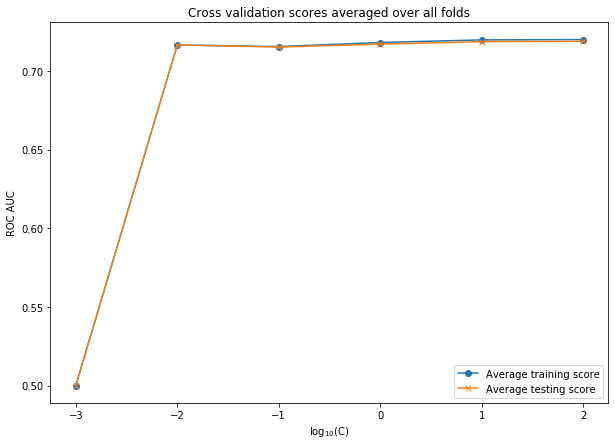

In [44]:
plt.figure(figsize = (10,7))
plt.plot(C_val_exponents, np.mean(cv_train_roc_auc, axis=0), '-o',
        label='Average training score')
plt.plot(C_val_exponents, np.mean(cv_test_roc_auc, axis=0), '-x',
        label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross validation scores averaged over all folds')
plt.show()

_____________________________________________________
**Up next, create interaction features for the case study data using scikit-learn's `PolynomialFeatures`. You should use 2 as the degree of polynomial features. Confirm that the number of new features makes sense.**

In [45]:
from sklearn.preprocessing import PolynomialFeatures

make_interactions = PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False)

poly_X = make_interactions.fit_transform(X)

poly_X.shape

(26664, 153)

_____________________________________________________
**Finally, repeat the cross-validation procedure and observe the model performance now.**

In [46]:
# Using the new features, make a 80:20 train/test split using a random seed of 24.**
X_train, X_test, y_train, y_test = train_test_split(poly_X, y.values, test_size = 0.2, random_state = 24)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((21331, 153), (21331,), (5333, 153), (5333,))

In [47]:
# Call the cross_val_C_search_pipe() function using the new training data.
# All other parameters should remain the same.
# Note that this training may take a few minutes due to the larger number of features.
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = cross_val_C_search_pipe(k_folds, C_vals, scale_lr_pipeline, X_train, y_train)

D:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Done with C = 100.0


D:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Done with C = 10.0


D:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Done with C = 1.0
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001


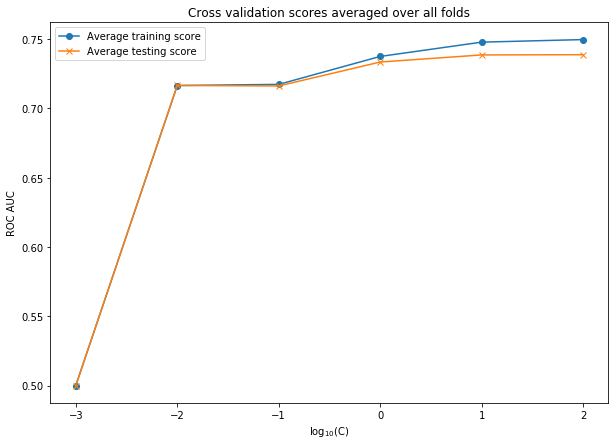

In [48]:
# Plot the average training and testing ROC AUC across folds, for each C value.
plt.figure(figsize = (10,7))
plt.plot(C_val_exponents, np.mean(cv_train_roc_auc, axis=0), '-o',
        label='Average training score')
plt.plot(C_val_exponents, np.mean(cv_test_roc_auc, axis=0), '-x',
        label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross validation scores averaged over all folds')
plt.show()

**Take a look at the above graph. Does the average cross-validation testing performance improve with the interaction features? Is regularization useful?**<br>
**OBSERVATION:** After comparing the cross validation graph over all folds with interation features and without interaction features, we can see a significant increase in the ROC AUC score in the cross validation graph with interaction features.